In [1]:
# %load_ext lab_black
import multiprocessing
import time

from mibian import BS
import numpy as np
import pandas as pd

import dash
from dash import dcc
from dash import html
from jupyter_dash import JupyterDash
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [9]:
"""Parameters

stock_low : float 
    Lowest underlying price in the price range.
stock_high : float 
    Highest underlying price in the price range.
strike : float
    Strike price of the option.
stock_increments : float
    This is the increments in the price range. A lower increment results in 
    more price points and a better graph, but longer compute time. 
max_days : int
    Number of days away from maturity to consider. 
"""

stock_low = 100
stock_high = 200
strike = 150
stock_increments = 0.10
max_days = 40

# Greek Caluclations
The first step is to create a 2d array of a range of underlying prices and days to maturity. 

For each point on this 2d array we calculate the greeks using the [Mibian Options Calculator](https://github.com/yassinemaaroufi/MibianLib) 

In [10]:
def create_greek(vars):
    """Create dataframe of greek values across stock values and days to expiration."""
    stockPrice = vars[0]
    daysToExpiration = vars[1]
    interestRate = 1.0
    volatility = 50
    strikePrice = vars[2]
    row = [stockPrice, daysToExpiration, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    greek = BS(
        [stockPrice, strikePrice, interestRate, daysToExpiration], volatility=volatility
    )

    row[2] = greek.callPrice
    row[3] = greek.putPrice
    row[4] = greek.callDelta
    row[5] = greek.putDelta
    row[6] = greek.callDelta2
    row[7] = greek.putDelta2
    row[8] = greek.callTheta
    row[9] = greek.putTheta
    row[10] = greek.callRho
    row[11] = greek.putRho
    row[12] = greek.vega
    row[13] = greek.gamma

    return row


def get_all_greeks(
    stock_low=50, stock_high=150, strike=100, stock_increments=1, max_days=90
):
    stockPrices = np.arange(stock_low, stock_high, stock_increments)
    daysToExpirations = np.arange(max_days, 0.0, -1)
    greek_vars = np.array(np.meshgrid(stockPrices, daysToExpirations)).T.reshape(-1, 2)
    gadd = np.zeros((greek_vars.shape[0], greek_vars.shape[1] + 1))
    gadd[:, :-1] = greek_vars
    gadd[:, -1:] = strike

    greek_vars = tuple(map(tuple, gadd))

    agg_results = list()

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count() - 2)
    for result in pool.imap_unordered(create_greek, greek_vars):
        agg_results.append(result)
    return agg_results


time_start = time.time()

cols = [
    "stockPrice",
    "daysToExpirations",
    "callPrice",
    "putPrice",
    "callDelta",
    "putDelta",
    "callDelta2",
    "putDelta2",
    "callTheta",
    "putTheta",
    "callRho",
    "putRho",
    "vega",
    "gamma",
]

greeks = get_all_greeks(
    stock_low=stock_low,
    stock_high=stock_high,
    strike=strike,
    stock_increments=stock_increments,
    max_days=max_days,
)
df = pd.DataFrame(greeks, columns=cols)
df = df.sort_values(["stockPrice", "daysToExpirations"], ascending=[True, False])

print(f"Shape: {df.shape}, elapsed time: {(time.time() - time_start):5.2f}")

# Display the data.
df

Shape: (40000, 14), elapsed time: 31.95


stockPrice  daysToExpirations  callPrice      putPrice  callDelta  \
0           100.0               40.0   0.048245  4.988395e+01   0.009131   
1           100.0               39.0   0.043287  4.988310e+01   0.008365   
5           100.0               38.0   0.038647  4.988256e+01   0.007630   
2           100.0               37.0   0.034320  4.988234e+01   0.006927   
4           100.0               36.0   0.030302  4.988243e+01   0.006256   
...           ...                ...        ...           ...        ...   
39992       199.9                5.0  49.920547  8.753683e-07   1.000000   
39996       199.9                4.0  49.916437  3.149956e-08   1.000000   
39997       199.9                3.0  49.912328  1.384155e-10   1.000000   
39998       199.9                2.0  49.908219  3.379422e-15   1.000000   
39999       199.9                1.0  49.904110  1.032547e-28   1.000000   

           putDelta  callDelta2     putDelta2  callTheta      putTheta  \
0     -9.908686e-01   -0.005766  9.931387e-01  -0.005117 -1.011904e-03   
1     -9.916347e-01   -0.005288  9.936438e-01  -0.004798 -6.932433e-04   
5     -9.923699e-01   -0.004829  9.941304e-01  -0.004483 -3.777020e-04   
2     -9.930732e-01   -0.004389  9.945977e-01  -0.004171 -6.604432e-05   
4     -9.937435e-01   -0.003969  9.950452e-01  -0.003865  2.409164e-04   
...             ...         ...           ...        ...           ...   
39992 -3.926847e-07   -0.999862  5.291536e-07  -0.004111 -2.353255e-06   
39996 -1.745206e-08   -0.999890  2.346778e-08  -0.004109 -1.296871e-07   
39997 -1.009675e-10   -0.999918  1.354788e-10  -0.004109 -9.921429e-10   
39998 -3.648791e-15   -0.999945  4.885151e-15  -0.004109 -5.332297e-14   
39999 -2.198488e-28   -0.999973  2.936736e-28  -0.004109 -6.368932e-27   

        callRho        putRho          vega         gamma  
0      0.000948 -1.632557e-01  8.149273e-03  1.487242e-03  
1      0.000848 -1.592552e-01  7.451669e-03  1.394800e-03  
5      0.000754 -1.552478e-01  6.784017e-03  1.303245e-03  
2      0.000667 -1.512334e-01  6.147080e-03  1.212802e-03  
4      0.000587 -1.472122e-01  5.541567e-03  1.123707e-03  
...         ...           ...           ...           ...  
39992  0.020545 -1.087302e-08  4.710858e-07  1.721184e-07  
39996  0.016437 -3.857717e-10  2.076537e-08  9.483682e-09  
39997  0.012328 -1.670287e-12  1.191240e-10  7.253960e-11  
39998  0.008219 -4.015193e-17  4.267444e-15  3.897939e-15  
39999  0.004109 -1.206878e-30  2.548056e-28  4.654855e-28  

[40000 rows x 14 columns]

# Chart choices
The following list out all the charts available for plotting. Use the index numbers
to select charts.

In [11]:
def get_greek_name(grk, printon=False):
    """Create label friendly mappings and also index numbers for
    choosing plots.
    """
    greek_column = [
        ("callPrice", "Call Price"),
        ("putPrice", "Put Price"),
        ("callDelta", "Call Delta"),
        ("putDelta", "Put Delta"),
        ("callDelta2", "Call Delta 2"),
        ("putDelta2", "Put Delta 2"),
        ("callTheta", "Call Theta"),
        ("putTheta", "Put Theta"),
        ("callRho", "Call Rho"),
        ("putRho", "Put Rho"),
        ("vega", "Vega"),
        ("gamma", "Gamma"),
    ]
    if printon:
        for i, row in enumerate(greek_column):
            print(i, row)

    return greek_column[grk]


# An example.
get_greek_name(1, printon=True)

0 ('callPrice', 'Call Price')
1 ('putPrice', 'Put Price')
2 ('callDelta', 'Call Delta')
3 ('putDelta', 'Put Delta')
4 ('callDelta2', 'Call Delta 2')
5 ('putDelta2', 'Put Delta 2')
6 ('callTheta', 'Call Theta')
7 ('putTheta', 'Put Theta')
8 ('callRho', 'Call Rho')
9 ('putRho', 'Put Rho')
10 ('vega', 'Vega')
11 ('gamma', 'Gamma')


('putPrice', 'Put Price')

Using callDelta, titled: Call Delta


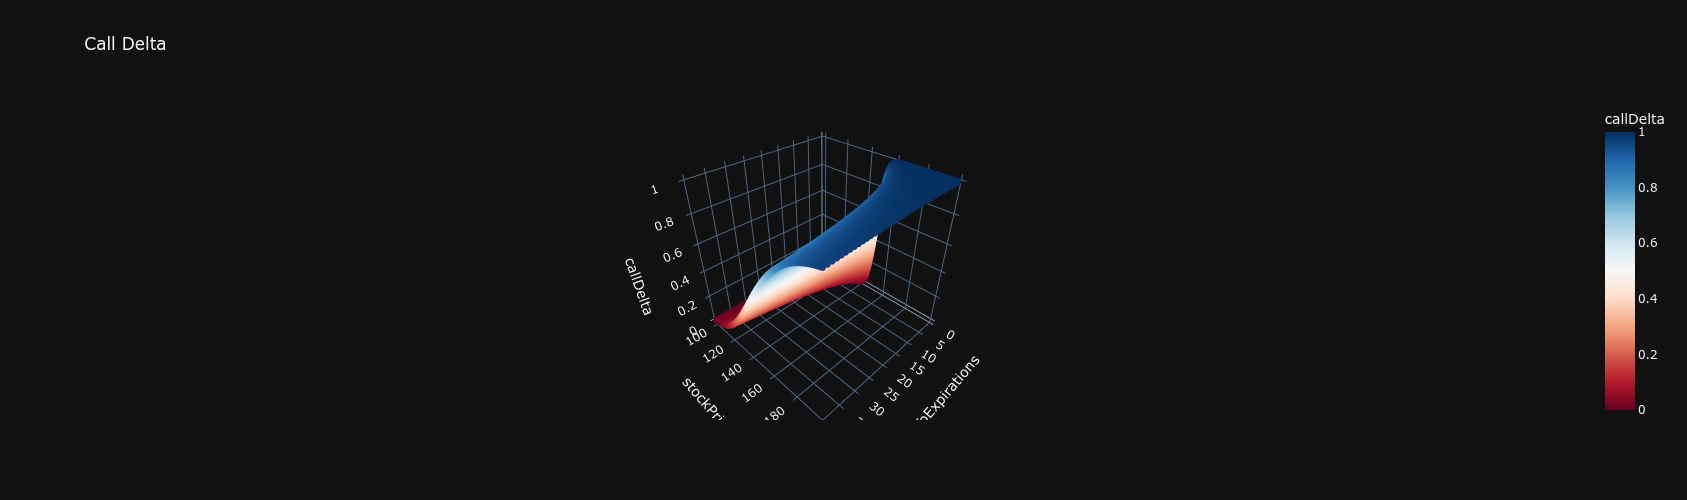

In [12]:
def greek_fig(
    greek,
    height=500,
    width=600,
    colors="rdbu",
    showfig=True,
):
    """Creates and shows a greek 3d figure using plotly.

    This will print plots here in the notebook. Use the plot indices above to select
    which plot to display.

    e.g. greek_fig(11) will show `Gamma`.

    More color patterns include:
    aggrnyl     agsunset    blackbody   bluered     blues       blugrn      bluyl       brwnyl
    bugn        bupu        burg        burgyl      cividis     darkmint    electric    emrld
    gnbu        greens      greys       hot         inferno     jet         magenta     magma
    mint        orrd        oranges     oryel       peach       pinkyl      plasma      plotly3
    pubu        pubugn      purd        purp        purples     purpor      rainbow     rdbu
    rdpu        redor       reds        sunset      sunsetdark  teal        tealgrn     turbo
    viridis     ylgn        ylgnbu      ylorbr      ylorrd      algae       amp         deep
    dense       gray        haline      ice         matter      solar       speed       tempo
    thermal     turbid      armyrose    brbg        earth       fall        geyser      prgn
    piyg        picnic      portland    puor        rdgy        rdylbu      rdylgn      spectral
    tealrose    temps       tropic      balance     curl        delta       oxy         edge
    hsv         icefire     phase       twilight    mrybm       mygbm
    """
    if showfig:
        print(f"Using {get_greek_name(greek)[0]}, titled: {get_greek_name(greek)[1]}")

    fig = px.scatter_3d(
        df,
        y="stockPrice",
        x="daysToExpirations",
        z=get_greek_name(greek)[0],
        color=get_greek_name(greek)[0],
        color_continuous_scale=colors,
        title=get_greek_name(greek)[1],
        # opacity=0.8,
        template="plotly_dark",
        height=height,
        width=width,
    )

    fig.update_traces(marker=dict(size=4, symbol="circle"))
    if showfig:
        fig.show()

    return fig


fig1 = greek_fig(2)
# fig2 = greek_fig(11)

# Greeks Dashboard
Run the following and you will have a dashboard with four plots. Select the charts using
the index numbers from above. Set `showfig` = False. 

Open a browser and navigate to `http://127.0.0.1:8070`


In [25]:

fig1 = greek_fig(2, showfig=False, colors="rdbu")
fig2 = greek_fig(11, showfig=False, colors="gnbu")
fig3 = greek_fig(6, showfig=False, colors="haline")
fig4 = greek_fig(10, showfig=False, colors="purd")


app = JupyterDash(__name__)

app.layout = html.Div(
    children=[
        html.H2(
            "A simulated Options Greeks exploration, visualization and dashboard using the Black Scholes Model"
        ),
        html.Div(
            [
                html.Div(
                    dcc.Graph(figure=fig1),
                    style={"width": "49%", "display": "inline-block"},
                ),
                html.Div(
                    dcc.Graph(figure=fig2),
                    style={"width": "49%", "display": "inline-block"},
                ),
            ]
        ),
        html.Div(
            [
                html.Div(
                    dcc.Graph(figure=fig3),
                    style={"width": "49%", "display": "inline-block"},
                ),
                html.Div(
                    dcc.Graph(figure=fig4),
                    style={"width": "49%", "display": "inline-block"},
                ),
            ]
        ),
    ]
)

app.run_server(
    mode="jupyterlab",
    port=8070,
    dev_tools_ui=True,
    debug=True,
    dev_tools_hot_reload=True,
    threaded=True,
)